In [52]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error,mean_squared_error
from sklearn import metrics

### For 60 Day

In [2]:
DATADIR = "/content/"
TRAIN_TEST_CUTOFF = '2016-04-21'
TRAIN_VALID_RATIO = 0.75

# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
# to implement F1 score for validation in a batch
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1macro(y_true, y_pred):
    f_pos = f1_m(y_true, y_pred)
    # negative version of the data and prediction
    f_neg = f1_m(1-y_true, 1-K.clip(y_pred,0,1))
    return (f_pos + f_neg)/2

def cnnpred_3d(seq_len=60, n_stocks=5, n_features=82, n_filters=(8,8,8), droprate=0.1):
    "3D-CNNpred model according to the paper"
    model = Sequential([
        Input(shape=(n_stocks, seq_len, n_features)),
        Conv2D(n_filters[0], kernel_size=(1,1), activation="relu", data_format="channels_last"),
        Conv2D(n_filters[1], kernel_size=(n_stocks,3), activation="relu"),
        MaxPool2D(pool_size=(1,2)),
        Conv2D(n_filters[2], kernel_size=(1,3), activation="relu"),
        MaxPool2D(pool_size=(1,2)),
        Flatten(),
        Dropout(droprate),
        Dense(1, activation="sigmoid")
    ])
    return model

def datagen(data, seq_len, batch_size, target_index, targetcol, kind):
    "As a generator to produce samples for Keras model"
    # Learn about the data's features and time axis
    input_cols = [c for c in data.columns if c[0] != targetcol]
    tickers = sorted(set(c for _,c in input_cols))
    n_features = len(input_cols) // len(tickers)
    index = data.index[data.index < TRAIN_TEST_CUTOFF]
    split = int(len(index) * TRAIN_VALID_RATIO)
    assert split > seq_len, "Training data too small for sequence length {}".format(seq_len)
    if kind == "train":
        index = index[:split]   # range for the training set
    elif kind == 'valid':
        index = index[split:]   # range for the validation set
    else:
        raise NotImplementedError
    # Infinite loop to generate a batch
    batch = []
    while True:
        # Pick one position, then clip a sequence length
        while True:
            t = random.choice(index)
            n = (data.index == t).argmax()
            if n-seq_len+1 < 0:
                continue # this sample is not enough for one sequence length
            frame = data.iloc[n-seq_len+1:n+1][input_cols]
            # convert frame with two level of indices into 3D array
            shape = (len(tickers), len(frame), n_features)
            X = np.full(shape, np.nan)
            for i,ticker in enumerate(tickers):
                X[i] = frame.xs(ticker, axis=1, level=1).values
            batch.append([X, data[targetcol][target_index][t]])
            break
        # if we get enough for a batch, dispatch
        if len(batch) == batch_size:
            X, y = zip(*batch)
            yield np.array(X), np.array(y)
            batch = []

def testgen(data, seq_len, target_index, targetcol):
    "Return array of all test samples"
    input_cols = [c for c in data.columns if c[0] != targetcol]
    tickers = sorted(set(c for _,c in input_cols))
    n_features = len(input_cols) // len(tickers)
    t = data.index[data.index >= TRAIN_TEST_CUTOFF][0]
    n = (data.index == t).argmax()
    batch = []
    for i in range(n+1, len(data)+1):
        # Clip a window of seq_len ends at row position i-1
        frame = data.iloc[i-seq_len:i]
        target = frame[targetcol][target_index][-1]
        frame = frame[input_cols]
        # convert frame with two level of indices into 3D array
        shape = (len(tickers), len(frame), n_features)
        X = np.full(shape, np.nan)
        for i,ticker in enumerate(tickers):
            X[i] = frame.xs(ticker, axis=1, level=1).values
        batch.append([X, target])
    X, y = zip(*batch)
    return np.array(X), np.array(y)

# Read data into pandas DataFrames
data = {}
for filename in os.listdir(DATADIR):
    if not filename.lower().endswith(".csv"):
        continue # read only the CSV files
    filepath = os.path.join(DATADIR, filename)
    X = pd.read_csv(filepath, index_col="Date", parse_dates=True)
    # basic preprocessing: get the name, the classification
    # Save the target variable as a column in dataframe for easier dropna()
    name = X["Name"][0]
    del X["Name"]
    cols = X.columns
    X["Target"] = (X["Close"].pct_change().shift(-1) > 0).astype(int)
    X.dropna(inplace=True)
    # Fit the standard scaler using the training dataset
    index = X.index[X.index < TRAIN_TEST_CUTOFF]
    index = index[:int(len(index) * TRAIN_VALID_RATIO)]
    scaler = StandardScaler().fit(X.loc[index, cols])
    # Save scale transformed dataframe
    X[cols] = scaler.transform(X[cols])
    data[name] = X

# Transform data into 3D dataframe (multilevel columns)
for key, df in data.items():
    df.columns = pd.MultiIndex.from_product([df.columns, [key]])
data = pd.concat(data.values(), axis=1)

# For 60 Days
seq_len = 60
batch_size = 128
n_epochs = 5
n_features = 82
n_stocks = 5

# Define AUC
Aucroc = tf.keras.metrics.AUC(curve="ROC")
# Produce CNNpred as a binary classification problem
model = cnnpred_3d(seq_len, n_stocks, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary() # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp3d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

history = model.fit(datagen(data, seq_len, batch_size, "DJI", "Target", "train"),
          validation_data=datagen(data, seq_len, batch_size, "DJI", "Target", "valid"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "DJI", "Target")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("MAE:", mean_absolute_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 60, 8)          664       
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 58, 8)          968       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 29, 8)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 27, 8)          200       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 13, 8)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 104)               0

In [16]:
def plot_loss(train_loss,val_loss):
  loss_train = history.history[train_loss]
  loss_val = history.history[val_loss]
  plt.plot(loss_train, 'g', label='Training Loss')
  plt.plot(loss_val, 'b', label='validation Loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [24]:
def plot_accuracy(acc_train,acc_val):
  acc_train = history.history[acc_train]
  acc_val = history.history[acc_val]
  plt.plot(acc_train, 'g', label='Training Accuracy')
  plt.plot(acc_val, 'b', label='validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [5]:
def plot_f1macro(f1_train,f1_val):
  f1_train = history.history[f1_train]
  f1_val = history.history[f1_val]
  plt.plot(f1_train, 'g', label='Training F1macro')
  plt.plot(f1_val, 'b', label='validation F1macro')
  plt.title('Training and Validation F1macro')
  plt.xlabel('Epochs')
  plt.ylabel('F1macro')
  plt.legend()
  plt.show()

In [32]:
def plot_Aucroc(auc_train,auc_val):
  aucroc_train = history.history[auc_train]
  aucroc_val = history.history[auc_val]
  plt.plot(aucroc_train, 'g', label='Training AucRoc')
  plt.plot(aucroc_val, 'b', label='validation AucRoc')
  plt.title('Training and Validation AucRoc')
  plt.xlabel('Epochs')
  plt.ylabel('AUC')
  plt.legend()
  plt.show()

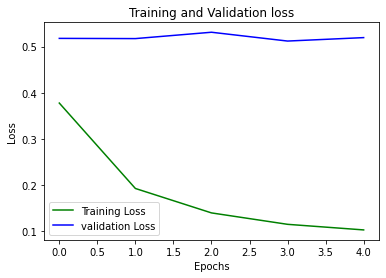

In [17]:
plot_loss('loss','val_loss')

In [18]:
history.history.keys()

dict_keys(['loss', 'acc', 'auc', 'f1macro', 'val_loss', 'val_acc', 'val_auc', 'val_f1macro'])

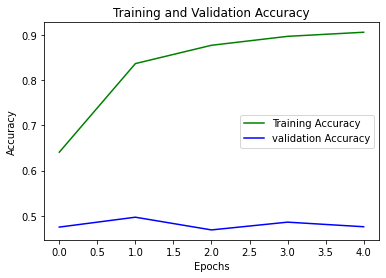

In [25]:
plot_accuracy('acc','val_acc')

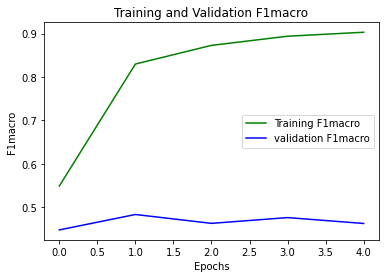

In [23]:
plot_f1macro('f1macro','val_f1macro')

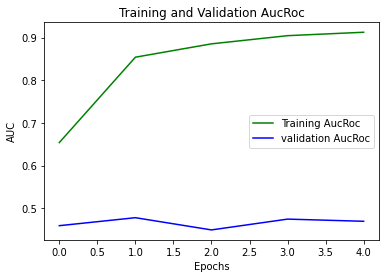

In [26]:
plot_Aucroc('auc','val_auc')

## For 30 Days

In [36]:
# For 30 Days
seq_len = 30
batch_size = 128
n_epochs = 5
n_features = 82
n_stocks = 5

# Produce CNNpred as a binary classification problem
model = cnnpred_3d(seq_len, n_stocks, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary() # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp3d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

history = model.fit(datagen(data, seq_len, batch_size, "DJI", "Target", "train"),
          validation_data=datagen(data, seq_len, batch_size, "DJI", "Target", "valid"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "DJI", "Target")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("MAE:", mean_absolute_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 5, 30, 8)          664       
                                                                 
 conv2d_7 (Conv2D)           (None, 1, 28, 8)          968       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 14, 8)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 1, 12, 8)          200       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 6, 8)          0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 48)               

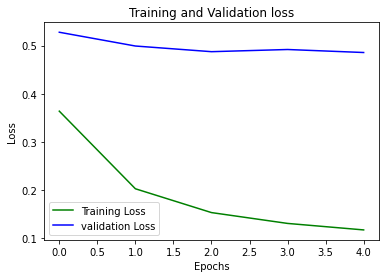

In [37]:
plot_loss('loss','val_loss')

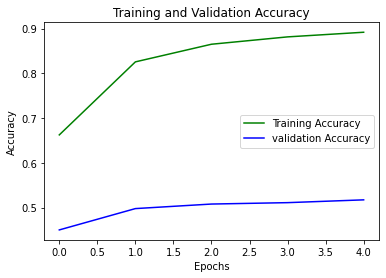

In [38]:
plot_accuracy('acc','val_acc')

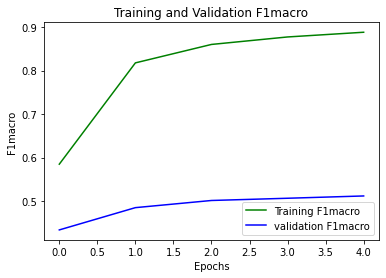

In [39]:
plot_f1macro('f1macro','val_f1macro')

In [40]:
history.history.keys()

dict_keys(['loss', 'acc', 'auc', 'f1macro', 'val_loss', 'val_acc', 'val_auc', 'val_f1macro'])

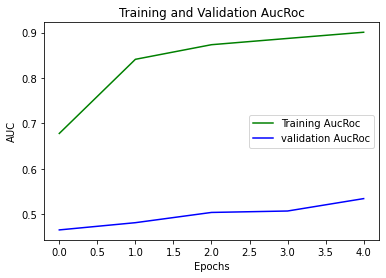

In [41]:
plot_Aucroc('auc','val_auc')

## For 20 Days

In [42]:
# For 20 Days
seq_len = 20
batch_size = 128
n_epochs = 5
n_features = 82
n_stocks = 5

# Produce CNNpred as a binary classification problem
model = cnnpred_3d(seq_len, n_stocks, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary() # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp3d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

model.fit(datagen(data, seq_len, batch_size, "DJI", "Target", "train"),
          validation_data=datagen(data, seq_len, batch_size, "DJI", "Target", "valid"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "DJI", "Target")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("MAE:", mean_absolute_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 5, 20, 8)          664       
                                                                 
 conv2d_10 (Conv2D)          (None, 1, 18, 8)          968       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 1, 9, 8)          0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 1, 7, 8)           200       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 1, 3, 8)          0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 24)               

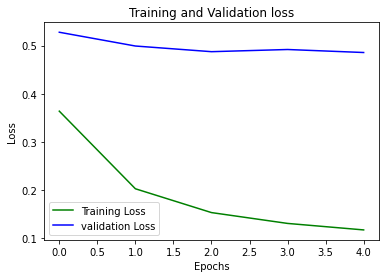

In [43]:
plot_loss('loss','val_loss')

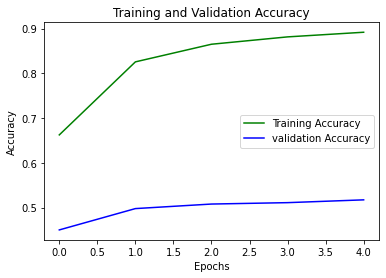

In [44]:
plot_accuracy('acc','val_acc')

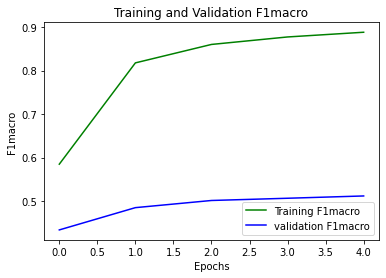

In [45]:
plot_f1macro('f1macro','val_f1macro')

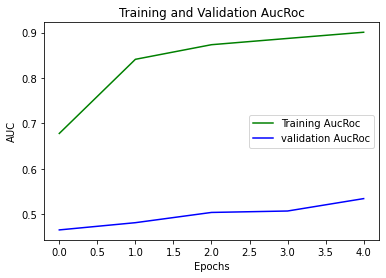

In [46]:
plot_Aucroc('auc','val_auc')

## For 10 Days

In [53]:
# For 10 Days
seq_len = 10
batch_size = 128
n_epochs = 5
n_features = 82
n_stocks = 5

# Produce CNNpred as a binary classification problem
model = cnnpred_3d(seq_len, n_stocks, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary() # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp3d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

model.fit(datagen(data, seq_len, batch_size, "DJI", "Target", "train"),
          validation_data=datagen(data, seq_len, batch_size, "DJI", "Target", "valid"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "DJI", "Target")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("MAE:", mean_absolute_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 5, 10, 8)          664       
                                                                 
 conv2d_16 (Conv2D)          (None, 1, 8, 8)           968       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 1, 4, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 1, 2, 8)           200       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 1, 1, 8)          0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 8)                

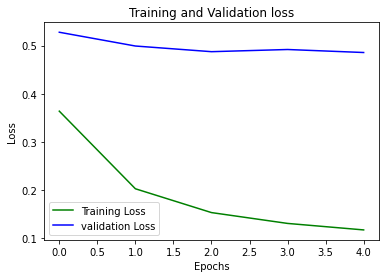

In [54]:
plot_loss('loss','val_loss')

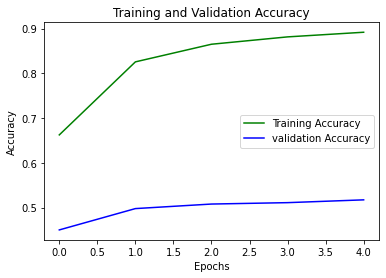

In [55]:
plot_accuracy('acc','val_acc')

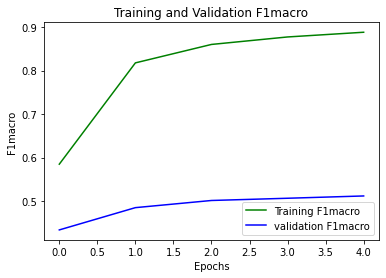

In [56]:
plot_f1macro('f1macro','val_f1macro')

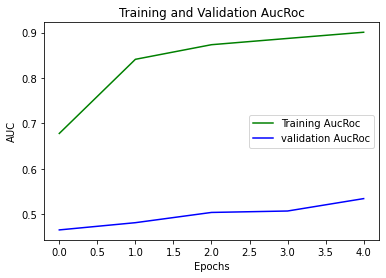

In [57]:
plot_Aucroc('auc','val_auc')